In [109]:
import pandas as pd
from pandas import read_excel

from collections import Counter
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.util import ngrams
import re

In [110]:
df = pd.read_csv('46.csv')

In [111]:
display(df)

,Final,GENRE
0,১০১০ গাণিতিক কুইজ,0
1,১১৮ টি মৌলের ইতিবৃত্ত,0
2,420 গণিত,0
3,৫০৫ গাণিতিক কুইজ,0
4,৫২টি প্রোগ্রামিং সমস্যা ও সমাধান,0
...,...,...
4607,হরর ১৩,3
4608,তন্দ্রাবিলাস,3
4609,শ্মশানঘাট,3
4610,ইলিয়ানা,3


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Final   4611 non-null   object
 1   GENRE   4612 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 72.2+ KB


In [113]:
# Change the GENRE datatype to category
df['GENRE'] = df['GENRE'].astype('category')

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Final   4611 non-null   object  
 1   GENRE   4612 non-null   category
dtypes: category(1), object(1)
memory usage: 40.9+ KB


In [115]:
df.dropna(inplace=True)

In [116]:
df.shape

(4611, 2)

In [117]:
df.drop_duplicates(subset=["Final"],inplace=True)

In [118]:
df.shape

(4446, 2)

In [120]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    #punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    punctuations = '''````£|¢|Ñ+-*/=EROero৳012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [121]:
df['Final'] = df.Final.apply(lambda x: preprocessing(str(x)))

In [122]:
display(df)

,Final,GENRE
0,১০১০ গাণিতিক কুইজ,0
1,১১৮ টি মৌলের ইতিবৃত্ত,0
2,গণিত,0
3,৫০৫ গাণিতিক কুইজ,0
4,৫২টি প্রোগ্রামিং সমস্যা ও সমাধান,0
...,...,...
4606,সাতটি রহস্য গল্প,3
4608,তন্দ্রাবিলাস,3
4609,শ্মশানঘাট,3
4610,ইলিয়ানা,3


In [104]:
from bangla_stemmer.stemmer import stemmer

In [28]:
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [29]:
df['Final'] = df.Final.apply(stem_text)

In [124]:
# import BnLemma as lm

# # Initialize the lemmatizer
# bl = lm.Lemmatizer()

# # Define a function to lemmatize a sentence with error handling
# def lemmatize_sentence(sentence):
#     try:
#         return bl.lemma(sentence)
#     except KeyError as e:
#         print(f"KeyError: {e} for sentence: {sentence}")
#         return sentence  


# df['Final'] = df['Final'].apply(lemmatize_sentence)

import BnLemma as lm
from collections import Counter

bl = lm.Lemmatizer()
lemmatized_words_counter = Counter()


def lemmatize_sentence(sentence):
    try:
        words = sentence.split()  # Split the sentence into words
        lemmatized_words = []     # To store lemmatized words
        for word in words:
            lemma_word = bl.lemma(word)  # Lemmatize each word
            if word != lemma_word:
                # Count the transformation in the format "original->lemmatized"
                transformation = word + '->' + lemma_word
                lemmatized_words_counter[transformation] += 1  
                l_word = transformation  # Store the transformation for final text
            else:
                l_word = word  # If no lemmatization, keep the word unchanged
            lemmatized_words.append(l_word)

        return ' '.join(lemmatized_words)  # Join lemmatized words back into a sentence
    except KeyError as e:
        print(f"KeyError: {e} for sentence: {sentence}")
        return sentence  # Return original sentence in case of an error

# Apply the function to the 'Final' column of the DataFrame
df['Final'] = df['Final'].apply(lemmatize_sentence)

# Display the top 40 most common lemmatized transformations
top_40_lemmatized_words = lemmatized_words_counter.most_common(40)
print("\nTop 40 lemmatized transformations:")
for transformation, count in top_40_lemmatized_words:
    print(f"{transformation}: {count} times")


KeyError: '' for sentence: ১৯৭১  মুক্তিযোদ্ধার বয়ান
KeyError: '' for sentence: মুক্তিযুদ্ধের বয়ানে ইসলাম

Top 40 lemmatized transformations:
মজার->মজা: 75 times
বিজ্ঞানের->বিজ্ঞান: 70 times
গণিতের->গণিত: 60 times
বাংলাদেশের->বাংলাদেশ: 55 times
গল্পে->গল্প: 38 times
বাংলার->বাংলা: 32 times
ইতিহাসের->ইতিহাস: 26 times
রাজনৈতিক->রাজনীতি: 23 times
বঙ্গবন্ধুর->বঙ্গবন্ধু: 21 times
মহাবিশ্ব->মহাবিশ্বে: 19 times
দ্বিতীয়->দ্বিতীয়: 19 times
মহাবিশ্বের->মহাবিশ্বে: 19 times
ছোটদের->ছোট: 19 times
সভ্যতা->সভ্য: 19 times
নির্বাচিত->নির্বাচক: 19 times
বাঙালির->বাঙালি: 19 times
অজানা->জানা: 18 times
পদার্থবিজ্ঞান->বিজ্ঞান: 17 times
জীবনের->জীবন: 17 times
মুক্তিযুদ্ধের->মুক্তিযুদ্ধ: 17 times
দেশে->দেশ: 17 times
ভূতের->ভূত: 17 times
গাণিতিক->গা: 16 times
সন্ধানে->সন্ধান: 16 times
রহস্যময়->রহস্য: 16 times
এই->এ: 15 times
ভারতের->ভারত: 15 times
চাচা->চা: 15 times
প্রেমের->প্রেম: 15 times
অঙ্কের->অঙ্কিতা: 14 times
ঢাকার->ঢাকা: 14 times
ভাসানী->ভাসান: 14 times
রাজ্যে->রাজ্জাক: 13 times
স্বাধীনতা->স্বাধীন:

In [107]:
stopwords = pd.read_excel('stopwords_bangla.xlsx')
stop = stopwords['words'].tolist()

In [108]:
display(len(stop))

739

In [59]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [60]:
df['Final'] = df.Final.apply(lambda x: stopwordRemoval(str(x)))

In [24]:
display(df)

,Final,GENRE
0,১০১০ কুইজ,0
1,১১৮ মৌল বৃত্ত,0
2,গণিত,0
3,৫০৫ কুইজ,0
4,৫২টি প্রোগ্রামিং সমস্যা সমাধান,0
...,...,...
4606,রহস্য,3
4608,তন্দ্রাবিলাস,3
4609,শ্মশান,3
4610,ইলিয়ানা,3


In [330]:
df = df.sample(frac=1).reset_index(drop=True)

## Count of Texts in Each Category

In [331]:
temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)
temp1.style.background_gradient(cmap='Purples')

/var/folders/zv/jrbwp45516zdz0j9bvpf13nh0000gn/T/ipykernel_83310/1747853096.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)


,GENRE,Final
2,2,1237
0,0,1166
1,1,1090
3,3,953


In [332]:
from collections import Counter

category_list = df.GENRE.unique().tolist()

for i in category_list:
    temp = df.loc[df['GENRE'] == i].copy() 
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words', 'count']
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In ' + str(i) + " Category")
    display(temp)

,Common_words,count
0,ইতিহাস,171
1,বাংলাদেশ,102
2,রাজনীতি,97
3,বঙ্গবন্ধু,70
4,ভারত,46
5,মুক্তিযুদ্ধ,46
6,বাংলা,40
7,আন্দোলন,37
8,ঢাকা,36
9,থেক,35


,Common_words,count
0,ভূত,31
1,চা,22
2,কমিটি,22
3,রহস্য,21
4,পাখি,19
5,বন্ধু,19
6,২,18
7,জাদু,17
8,টিনটিন,16
9,চৌধুরী,15


,Common_words,count
0,সমগ্র,32
1,প্রেম,28
2,উপন্যাস,25
3,জীবন,22
4,নির্বাচক,17
5,ভালোবাসা,16
6,আম,15
7,না,15
8,রচনা,14
9,খণ্ড,13


,Common_words,count
0,বিজ্ঞান,247
1,গণিত,192
2,মজ,62
3,অলিম্পিয়াড,45
4,মহাবিশ্বে,44
5,কথা,40
6,খণ্ড,39
7,প্রশ্ন,35
8,প্রোগ্রামিং,34
9,রহস্য,33


In [333]:
df['temp_list'] = df['Final'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,বিজ্ঞান,252
1,ইতিহাস,194
2,গণিত,192
3,বাংলাদেশ,118
4,রাজনীতি,97
5,কথা,82
6,মজ,75
7,খণ্ড,73
8,বঙ্গবন্ধু,73
9,জীবন,68


In [334]:
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["Final"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top20 = esBigram_wordlist.most_common(20)
    top20 = dict(top20)
    df_ngrams = pd.DataFrame(sorted(top20.items(), key=lambda x: x[1])[::-1])
    df_ngrams.columns = ['Ngram','count']
    return df_ngrams


# function to visualize the top 20 n-grams
def show(train):
    display(train.head(20))

In [335]:
for i in category_list:
    temp=df.loc[df['GENRE'] == i].copy()
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_unigrams = get_ngrams(temp,1)
    print("\t\t\t====== Unigrams of "+str(i)+"======")   
    show(train_unigrams)

			====== Unigrams of 2======


,Ngram,count
0,"(ইতিহাস,)",171
1,"(বাংলাদেশ,)",102
2,"(রাজনীতি,)",97
3,"(বঙ্গবন্ধু,)",70
4,"(মুক্তিযুদ্ধ,)",46
5,"(ভারত,)",46
6,"(বাংলা,)",40
7,"(আন্দোলন,)",37
8,"(ঢাকা,)",36
9,"(থেক,)",35


			====== Unigrams of 1======


,Ngram,count
0,"(ভূত,)",31
1,"(কমিটি,)",22
2,"(চা,)",22
3,"(রহস্য,)",21
4,"(বন্ধু,)",19
5,"(পাখি,)",19
6,"(২,)",18
7,"(জাদু,)",17
8,"(টিনটিন,)",16
9,"(চৌধুরী,)",15


			====== Unigrams of 3======


,Ngram,count
0,"(সমগ্র,)",32
1,"(প্রেম,)",28
2,"(উপন্যাস,)",25
3,"(জীবন,)",22
4,"(নির্বাচক,)",17
5,"(ভালোবাসা,)",16
6,"(না,)",15
7,"(আম,)",15
8,"(রচনা,)",14
9,"(ভালো,)",13


			====== Unigrams of 0======


,Ngram,count
0,"(বিজ্ঞান,)",247
1,"(গণিত,)",192
2,"(মজ,)",62
3,"(অলিম্পিয়াড,)",45
4,"(মহাবিশ্বে,)",44
5,"(কথা,)",40
6,"(খণ্ড,)",39
7,"(প্রশ্ন,)",35
8,"(প্রোগ্রামিং,)",34
9,"(রহস্য,)",33


In [336]:
for i in category_list:
    temp=df.loc[df['GENRE'] == i].copy()
    temp['temp_list'] = temp['Final'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_bigrams = get_ngrams(temp,2)
    print("\t\t\t====== Bigrams of "+str(i)+" ======")   
    show(train_bigrams)

			====== Bigrams of 2 ======


,Ngram,count
0,"(শেখ, মুজিব)",13
1,"(ভাষা, আন্দোলন)",13
2,"(বাংলাদেশ, মুক্তিযুদ্ধ)",10
3,"(বাংলাদেশ, রাজনীতি)",9
4,"(প্রাচীন, সভ্য)",9
5,"(সভ্য, সিরিজ)",8
6,"(রাজনীতি, ইতিহাস)",7
7,"(মওকা, ভাসান)",6
8,"(১ম, খণ্ড)",6
9,"(মুসলিম, ইতিহাস)",6


			====== Bigrams of 1 ======


,Ngram,count
0,"(চা, চৌধুরী)",14
1,"(দুঃসাহস, টিনটিন)",9
2,"(বেসিক, আল)",6
3,"(হাঁস, ছানা)",5
4,"(ফ্যান্টম, ডাইজেস্ট)",5
5,"(ঠাকুর, ঝুল)",5
6,"(ছোটা, ভীম)",5
7,"(গ্রাফিক, নভেল)",5
8,"(ফরচুন, পার্ট)",4
9,"(হান্টার্স, ফরচুন)",4


			====== Bigrams of 3 ======


,Ngram,count
0,"(হুমায়ূন, আহমেদ)",12
1,"(আহমেদ, রচনা)",11
2,"(ফ্রান্স, কাফকা)",5
3,"(প্রেম, উপন্যাস)",5
4,"(নির্বাচক, ছোটগল্প)",4
5,"(অলংকার, সমগ্র)",4
6,"(১ম, খণ্ড)",4
7,"(সমগ্র, নীল)",3
8,"(জীবন, আম)",3
9,"(শাহাদুজ্জামান, সংগ্রহ)",3


			====== Bigrams of 0 ======


,Ngram,count
0,"(গণিত, অলিম্পিয়াড)",25
1,"(বিজ্ঞান, বিজ্ঞান)",13
2,"(বিজ্ঞান, মজ)",12
3,"(মজ, গণিত)",11
4,"(মজ, কথা)",10
5,"(২য়, খণ্ড)",9
6,"(বিজ্ঞান, গণিত)",9
7,"(সমস্যা, সমাধান)",9
8,"(বিজ্ঞান, ইতিহাস)",8
9,"(অলিম্পিয়াড, প্রশ্ন)",8


In [337]:
for i in category_list:
    temp=df.loc[df['GENRE'] == i].copy()
    #display(temp)
    temp['temp_list'] = temp['Final'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_trigrams = get_ngrams(temp,3)  
    show(train_trigrams)
    print("====== Trigrams of "+str(i)+" ======") 

,Ngram,count
0,"(প্রাচীন, সভ্য, সিরিজ)",8
1,"(শেখ, মুজিব, রহমান)",6
2,"(বঙ্গবন্ধু, শেখ, মুজিব)",5
3,"(আবদুল, হাম, খাওয়া)",5
4,"(ভাষা, আন্দোলন, ইতিহাস)",4
5,"(হাম, খাওয়া, ভাসান)",4
6,"(হোস, শহীদ, সোহরাওয়ার্দী)",3
7,"(বাংলাদেশ, মুক্তিযুদ্ধ, ইতিহাস)",3
8,"(বঙ্গবন্ধু, ৬, দফা)",3
9,"(ইতিহাস, প্রাচীন, যুগ)",3


====== Trigrams of 2 ======


,Ngram,count
0,"(হান্টার্স, ফরচুন, পার্ট)",4
1,"(গ্রাফিক, নভেল, মুজিব)",4
2,"(সচিত্র, আরব, নীর)",3
3,"(অব, শার্লক, হোম)",3
4,"(নন্দ, ফন্টে, সমগ্র)",2
5,"(দুঃসাহস, টিনটিন, বোম্বে)",2
6,"(পপ, বই, বাংলা)",2
7,"(বুক, অব, শার্লক)",2
8,"(বাঁটা, দি, গ্রেট)",2
9,"(জাল, ১ম, পর্ব)",1


====== Trigrams of 1 ======


,Ngram,count
0,"(হুমায়ূন, আহমেদ, রচনা)",11
1,"(বাংলাদেশ, নির্বাচক, ছোটগল্প)",3
2,"(আবদুল, হাই, রচনা)",3
3,"(হাস, আবদুল, হাই)",3
4,"(ওল, ম্যান, অ্যান্ড)",2
5,"(দি, ওল, ম্যান)",2
6,"(আদর্শ, হিন্দু, হোটেল)",2
7,"(মিসির, আল, সমগ্র)",2
8,"(হৃদয়, খুঁড়ে, ভাব)",1
9,"(হাউন্ডেড, হৃদয়, খুঁড়ে)",1


====== Trigrams of 3 ======


,Ngram,count
0,"(পদার্থ, মজ, কথা)",8
1,"(বাংলাদেশ, গণিত, অলিম্পিয়াড)",5
2,"(বিজ্ঞান, মজ, প্রশ্ন)",5
3,"(অলিম্পিয়াড, প্রশ্ন, সমাধান)",4
4,"(পাইথন, প্রোগ্রামিং, শেখ)",4
5,"(গণিত, অলিম্পিয়াড, হাত)",4
6,"(পত্র, দ্বাদশ, শ্রেণি)",4
7,"(গণিত, অলিম্পিয়াড, প্রশ্ন)",4
8,"(বিজ্ঞান, আবিষ্কার, কথা)",3
9,"(বিজ্ঞান, রাজ্জাক, প্রশ্ন)",3


====== Trigrams of 0 ======


In [338]:
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt


font_path = "Siyamrupali.ttf"

def generate_wordcloud(data, title):
    data = [tuple(x) for x in data.values]
    wc = WordCloud(font_path=font_path, width=1080, height=720, max_words=150, colormap="Dark2").generate_from_frequencies(dict(data))
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap("Word Cloud of " + title, 60)), fontsize=13)
    plt.show()


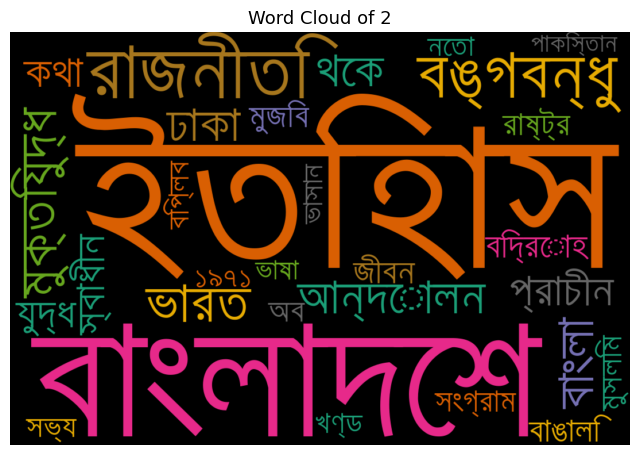

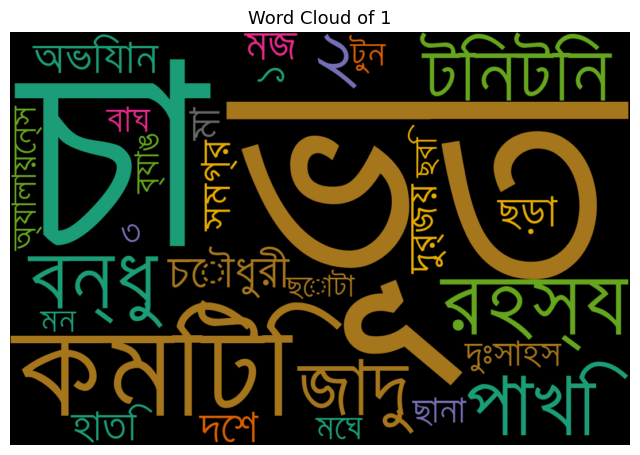

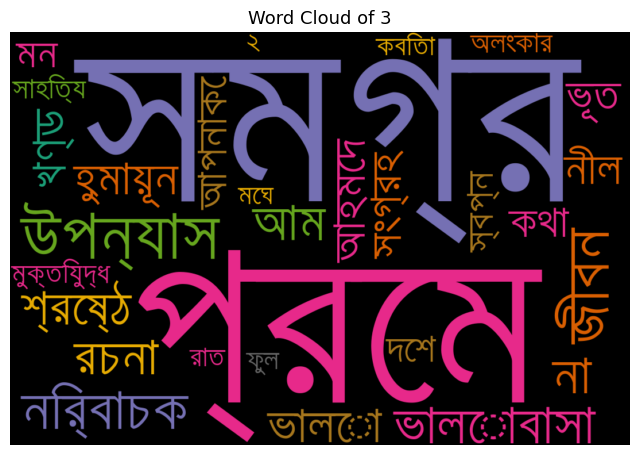

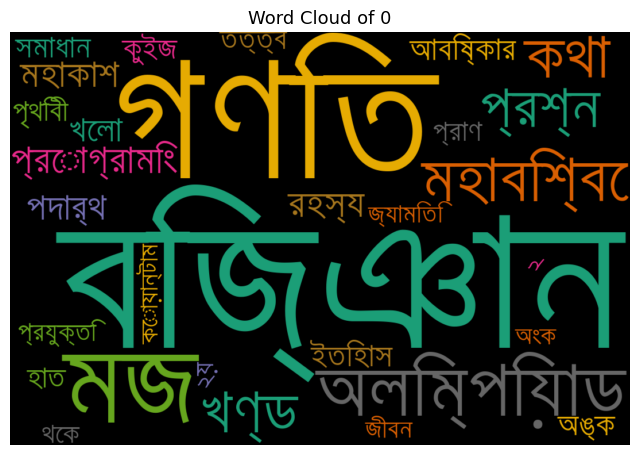

In [339]:
for i in category_list:
    temp = df.loc[df['GENRE'] == i].copy() 
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(30))
    temp.columns = ['Common_words', 'count']
    generate_wordcloud(temp,str(i))

In [340]:
import numpy as np

In [341]:
# Split the dataset into train (70%) and temp (30%)
train1, temp1 = train_test_split(df, random_state=42, test_size=0.3)

# Split the temp dataset into test (20%) and validation (10%)
test1, val1 = train_test_split(temp1, random_state=42, test_size=0.3333)

# Initialize lists for sentences
training_sentences = []
testing_sentences = []
validation_sentences = []

# Extract sentences and labels for training set
train_sentences = train1['Final'].values
train_labels = train1['GENRE'].values
for i in range(train_sentences.shape[0]): 
    x = str(train_sentences[i])
    training_sentences.append(x)
training_sentences = np.array(training_sentences)

# Extract sentences and labels for testing set
test_sentences = test1['Final'].values
test_labels = test1['GENRE'].values
for i in range(test_sentences.shape[0]): 
    x = str(test_sentences[i])
    testing_sentences.append(x)
testing_sentences = np.array(testing_sentences)

# Extract sentences and labels for validation set
val_sentences = val1['Final'].values
val_labels = val1['GENRE'].values
for i in range(val_sentences.shape[0]): 
    x = str(val_sentences[i])
    validation_sentences.append(x)
validation_sentences = np.array(validation_sentences)

# Convert labels to categorical
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)
val_labels = keras.utils.to_categorical(val_labels)

# Print dataset shapes
print("Training Set Length: " + str(len(train1)))
print("Testing Set Length: " + str(len(test1)))
print("Validation Set Length: " + str(len(val1)))
print("training_sentences shape: " + str(training_sentences.shape))
print("testing_sentences shape: " + str(testing_sentences.shape))
print("validation_sentences shape: " + str(validation_sentences.shape))
print("train_labels shape: " + str(train_labels.shape))
print("test_labels shape: " + str(test_labels.shape))
print("val_labels shape: " + str(val_labels.shape))

Training Set Length: 3112
Testing Set Length: 889
Validation Set Length: 445
training_sentences shape: (3112,)
testing_sentences shape: (889,)
validation_sentences shape: (445,)
train_labels shape: (3112, 4)
test_labels shape: (889, 4)
val_labels shape: (445, 4)


In [342]:
vocab_size = 3200
embedding_dim = 300
max_length = 8
trunc_type='post'
oov_tok = "<OOV>"

In [343]:
from keras.preprocessing.text import Tokenizer

In [344]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)



test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(validation_sentences)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

2928
Word index length:2928


In [345]:
word_index

{'<OOV>': 1,
 'বিজ্ঞান': 2,
 'গণিত': 3,
 'ইতিহাস': 4,
 'বাংলাদেশ': 5,
 'রাজনীতি': 6,
 'কথা': 7,
 'জীবন': 8,
 'বঙ্গবন্ধু': 9,
 'মজ': 10,
 'খণ্ড': 11,
 'সমগ্র': 12,
 'রহস্য': 13,
 'থেক': 14,
 'মুক্তিযুদ্ধ': 15,
 'ভূত': 16,
 'বাংলা': 17,
 'ঢাকা': 18,
 'ভারত': 19,
 'অব': 20,
 '২': 21,
 'মহাবিশ্বে': 22,
 'আম': 23,
 'অলিম্পিয়াড': 24,
 'দেশ': 25,
 'আন্দোলন': 26,
 'পৃথিবী': 27,
 'প্রাচীন': 28,
 'প্রশ্ন': 29,
 'খেলা': 30,
 'মা': 31,
 'প্রোগ্রামিং': 32,
 'ভাষা': 33,
 'চা': 34,
 '১': 35,
 'মহাকাশ': 36,
 'যুদ্ধ': 37,
 'পদার্থ': 38,
 'মন': 39,
 'হাত': 40,
 'না': 41,
 'তত্ত্ব': 42,
 'শেখ': 43,
 '১ম': 44,
 'মুজিব': 45,
 'প্রেম': 46,
 '৩': 47,
 '২য়': 48,
 'কমিটি': 49,
 'বিদ্রোহ': 50,
 'রাষ্ট্র': 51,
 'কাহিনী': 52,
 'মুসলিম': 53,
 'বাঙালি': 54,
 'আল': 55,
 'হওয়া': 56,
 'জাদু': 57,
 'সমাধান': 58,
 'ভাবনা': 59,
 'পাখি': 60,
 'আহমেদ': 61,
 'প্রাণ': 62,
 'সংগ্রাম': 63,
 'উপন্যাস': 64,
 '১৯৭১': 65,
 'ভালোবাসা': 66,
 'সভ্য': 67,
 'মেঘ': 68,
 'নেতা': 69,
 'স্বাধীন': 70,
 'সের': 71,
 'অঙ্ক': 72,
 'বিপ্লব': 7

In [346]:
print("Sentence :--> \n")
print(training_sentences[1]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[1])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[1])

Sentence :--> 

গণিত নবম দশম শ্রেণি ২০২৩

Sentence Tokenized and Converted into Sequence :--> 

[3, 1154, 492, 224, 704]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    3 1154  492  224  704]


In [347]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32, return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    #Dropout(0.4),
    Dense(32 ,kernel_regularizer=regularizers.l2(0.01),activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

In [348]:
optimizers = tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])


In [349]:
logdir='lstm'
batch = 256

In [350]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping= tf.keras.callbacks.EarlyStopping(patience= 6, restore_best_weights= True, monitor='val_loss')

In [351]:
history=model.fit(padded,train_labels,epochs=60,batch_size= batch,validation_data=(val_padded,val_labels),callbacks=[tensorboard_callback,early_stopping])

Epoch 1/60
13/13 [==============================] - 2s 45ms/step - loss: 1.6999 - accuracy: 0.2735 - val_loss: 1.6971 - val_accuracy: 0.2764
Epoch 2/60
13/13 [==============================] - 0s 18ms/step - loss: 1.6946 - accuracy: 0.2960 - val_loss: 1.6926 - val_accuracy: 0.3146
Epoch 3/60
13/13 [==============================] - 0s 17ms/step - loss: 1.6901 - accuracy: 0.2966 - val_loss: 1.6879 - val_accuracy: 0.3034
Epoch 4/60
13/13 [==============================] - 0s 17ms/step - loss: 1.6841 - accuracy: 0.3223 - val_loss: 1.6833 - val_accuracy: 0.3146
Epoch 5/60
13/13 [==============================] - 0s 16ms/step - loss: 1.6790 - accuracy: 0.3268 - val_loss: 1.6783 - val_accuracy: 0.3663
Epoch 6/60
13/13 [==============================] - 0s 17ms/step - loss: 1.6738 - accuracy: 0.3477 - val_loss: 1.6733 - val_accuracy: 0.4067
Epoch 7/60
13/13 [==============================] - 0s 16ms/step - loss: 1.6685 - accuracy: 0.3432 - val_loss: 1.6681 - val_accuracy: 0.4270
Epoch 8/60
13

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


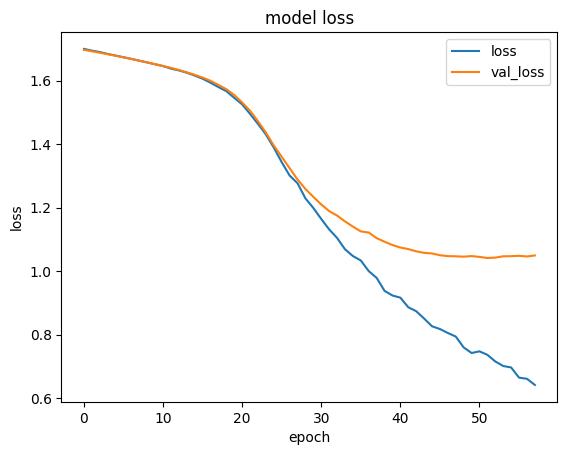

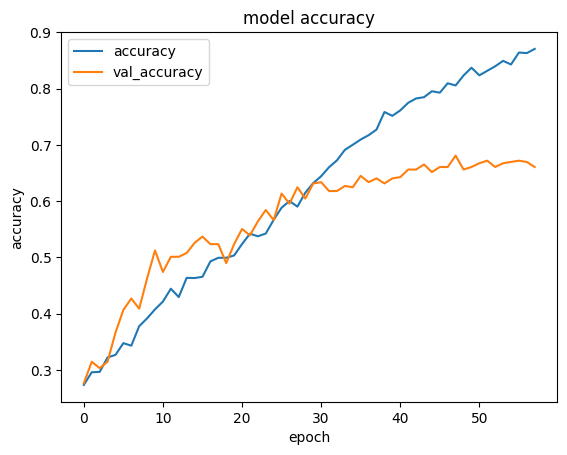

In [352]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [353]:
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=batch)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=batch)
print("The test accuracy is: "+str(loss_and_metrics[1]))

13/13 [==============================] - 0s 5ms/step - loss: 0.5883 - accuracy: 0.9091
The train accuracy is: 0.9090616703033447
4/4 [==============================] - 0s 4ms/step - loss: 0.9691 - accuracy: 0.7098
The test accuracy is: 0.7097862958908081


In [354]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_true, y_pred, target_names=target_names))

28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     class 0       0.88      0.74      0.80       256
     class 1       0.65      0.60      0.62       208
     class 2       0.82      0.79      0.81       243
     class 3       0.50      0.69      0.58       182

    accuracy                           0.71       889
   macro avg       0.71      0.70      0.70       889
weighted avg       0.73      0.71      0.72       889



28/28 [==============================] - 0s 1ms/step


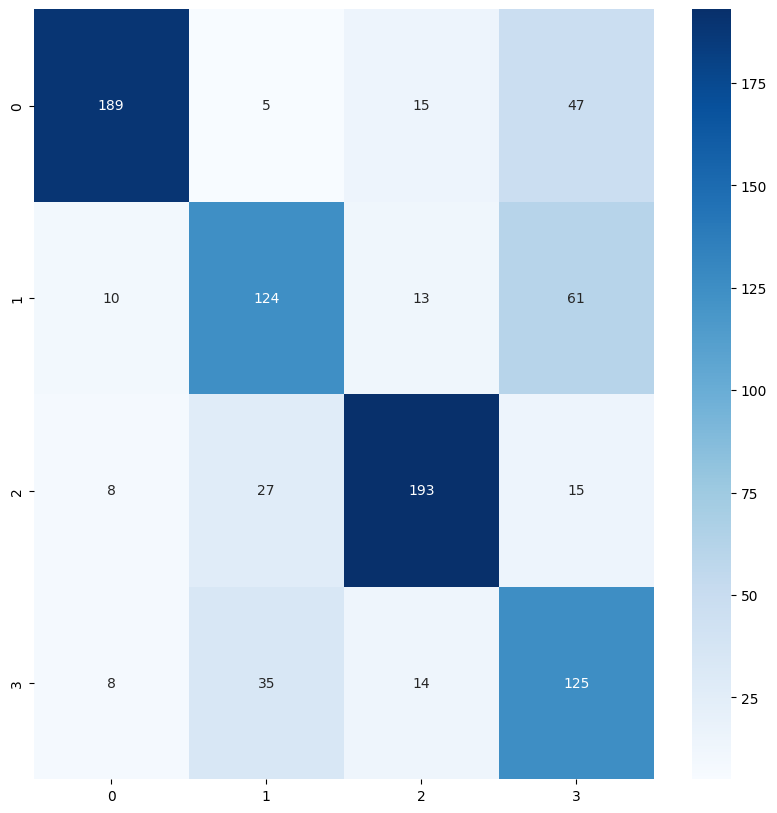

In [355]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(testing_padded)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_labels, axis=1)
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

In [356]:
#import os

In [357]:
#model.save(os.path.join("Pre_models", 'Lstm2.h5'))